# 1. Cleaning The Data

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

## Read the CSV file

In [2]:
df = pd.read_csv('Data/spam.csv',encoding = "ISO-8859-1")

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


##  Drop the unnamed columns because of null values

In [5]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

## Rename the Columns for ease 

In [6]:
df.rename(columns={'v1':'Target','v2':'Text'},inplace=True)

In [7]:
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.shape

(5572, 2)

## Check for null values

In [9]:
df.isna().sum()

Target    0
Text      0
dtype: int64

## Check for duplicates & Drop if any

In [10]:
df.duplicated().sum()

403

In [11]:
df.drop_duplicates(keep='first',inplace=True)

In [12]:
df.duplicated().sum()

0

## Encode the target column

In [13]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

F:\Conda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
df['Target'] = enc.fit_transform(df['Target'])

.

# 2. Exploratory Data Analysis

## Import visualization libraries

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

## Check for imbalance

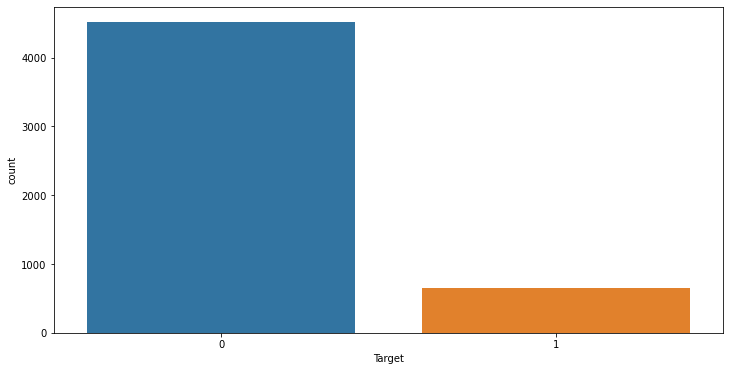

In [16]:
plt.figure(figsize=(12,6))
sns.countplot(x=df["Target"])
plt.show()

There is clear imbalance

## Check how many total charachters are used

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Viraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
df['Text'].apply(len)

0       111
1        29
2       155
3        49
4        61
       ... 
5567    161
5568     37
5569     57
5570    125
5571     26
Name: Text, Length: 5169, dtype: int64

In [19]:
df['Charachters'] = df['Text'].apply(len)

## Number of words

In [20]:
df['Words'] = df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))

## Number of sentences

In [21]:
df['Sentences'] = df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))

## Spam vs No Spam - Visualization

In [22]:
def hamvsspam(df,column,Colors,title):
    df = df.groupby('Target').mean().reset_index()
    plt.figure(figsize=(12,6))
    plt.pie(df[column], labels=['No Spam','Spam'],autopct="%0.2f%%",colors=Colors)
    plt.title(f"Average Number of {column} in Spam vs Non Spam messages",fontsize=15)
    return plt.show()
    

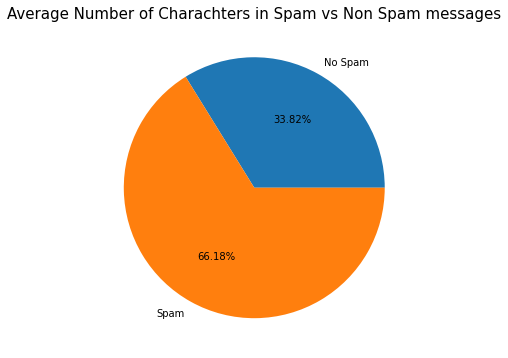

In [23]:
hamvsspam(df,'Charachters',None,'Charachters')

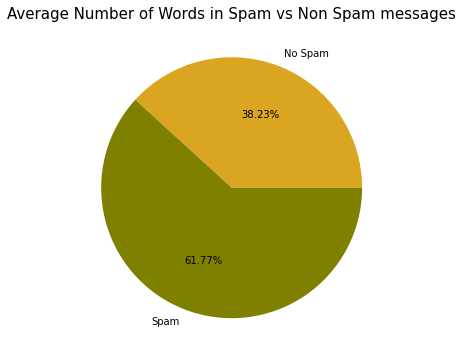

In [24]:
hamvsspam(df,'Words',['goldenrod','olive'],'Words')

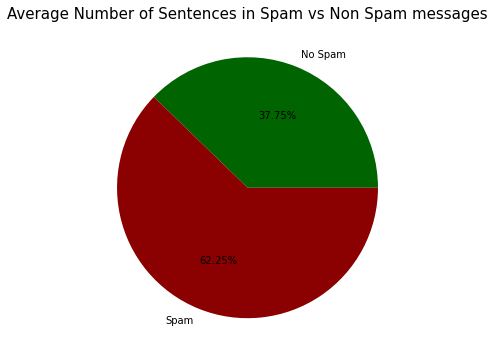

In [25]:
hamvsspam(df,'Sentences',['darkgreen','darkred'],'Sentences')

As you can clearly see Spam messages are more lengthy ie. contain more words,sentences and charachters

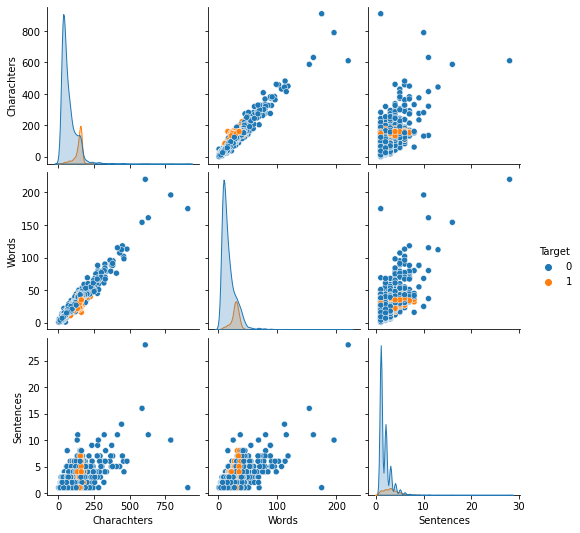

In [26]:
sns.pairplot(df,hue='Target')

## Check correlations

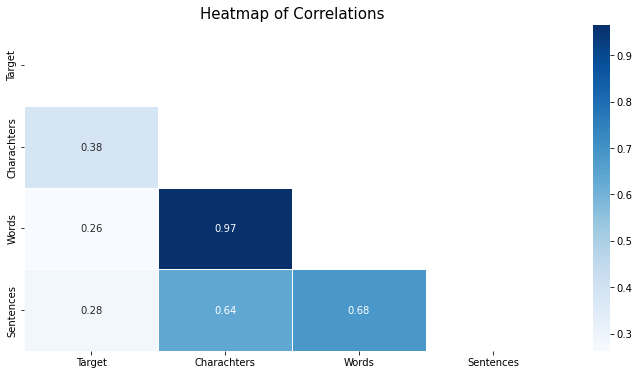

In [27]:
plt.figure(figsize=(12,6))
mask = np.triu(df.corr())
sns.heatmap(df.corr(),mask=mask,annot=True,cmap=sns.color_palette("Blues", as_cmap=True),linewidth=.5)
plt.title('Heatmap of Correlations',fontsize=15)
plt.show()

Its obvious that charachters words and sentences have multicollinearity. While making model we will only keep charachters column as it has the highest relation with target out of the 3

## Most used words 

In [28]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [29]:
def preprocess(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [30]:
df['Processed'] = df['Text'].apply(preprocess)

## lets create wordclouds

In [31]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,background_color='white')

## For Non spam

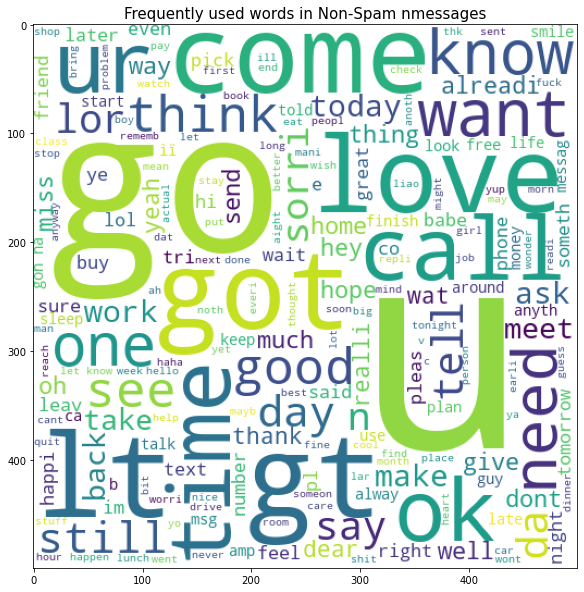

In [32]:
plt.figure(figsize=(14,10))
wc.generate(df[df['Target']==0]['Processed'].str.cat(sep=' '))
plt.title("Frequently used words in Non-Spam nmessages",fontsize=15)
plt.imshow(wc)

## For Spam

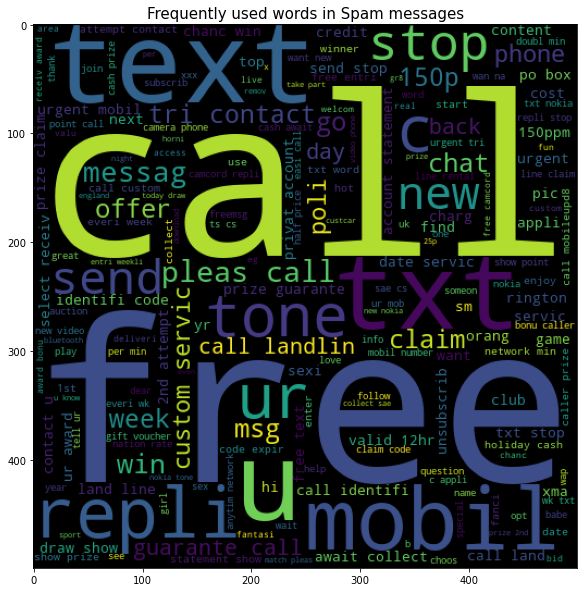

In [34]:
wc = WordCloud(width=500,height=500,background_color='black')
plt.figure(figsize=(14,10))
wc.generate(df[df['Target']==1]['Processed'].str.cat(sep=' '))
plt.title("Frequently used words in Spam messages",fontsize=15)
plt.imshow(wc)

It seems like spam messages mostly use the words : 'Free', 'Text', 'Call', 'Claim', 'Win'


Where as non spam messages have : 'Go', 'come', 'Time'

In [35]:
spam_corp = []
for i in df[df['Target']==1]['Processed'].tolist():
    for j in i.split():
        spam_corp.append(j)

In [36]:
from collections import Counter

F:\Conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


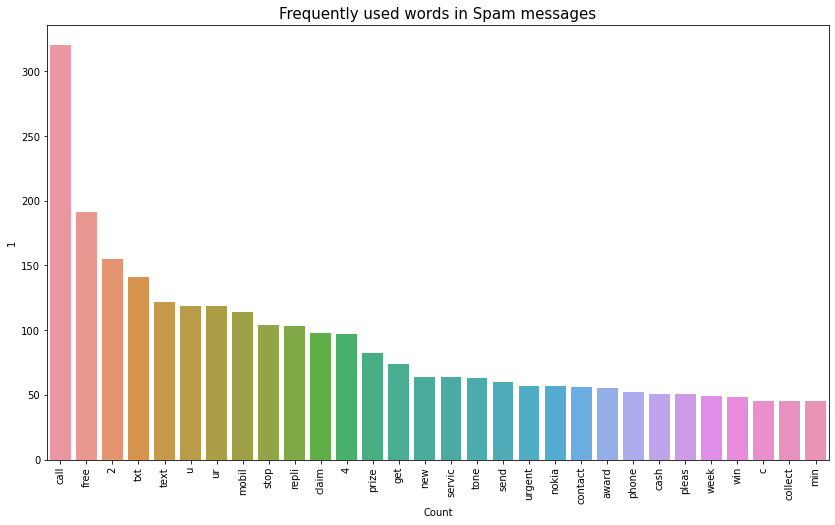

In [37]:
plt.figure(figsize=(14,8))
sns.barplot(pd.DataFrame(Counter(spam_corp).most_common(30))[0],pd.DataFrame(Counter(spam_corp).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.xlabel('Words')
plt.xlabel('Count')
plt.title("Frequently used words in Spam messages",fontsize=15)
plt.show()